# Analysis of NCAA Basketball Data
In this notebook, I analyze a variety of information about NCAA basketball. I use a large database hosted on Google Bigquery, which can be found at https://www.kaggle.com/ncaa/ncaa-basketball.


The database contains the following tables:
- mascots
- team_colors
- mbb_teams
- mbb_historical_teams_seasons - historical season data (1894/1895-present)
- mbb_historical_teams_games - final scores, one entry per team per game (1996/1997-present)
- mbb_historical_tournament_games - historical data about tournament games (1984/1985-present)
- mbb_games_sr - team level box scores (2013/2014-2017/2018)
- mbb_pbp_sr - play by play information about games (2013/2014-present)
- mbb_players_games_sr - player level box scores (2013/2014-2017/2018)
- mbb_teams_games_sr - team level box scores (2013/2014-2017/2018)

Because I attended Boston College and Wisconsin, and Wisconsin has the much better basketball team, I will mainly attempt to get a sense of Wisconsin's program and its performance over the years. Based on the database tables, it looks like I may be able to answer the following questions:
- What is Wisconin's mascot?
- What is Wisconsin's team color?
- Where does Wisconsin play home games?
- Where has Wisconsin played the most games?
- Home vs. away performance
- Highest scoring games
- Tournament performance
- Chokes vs. Upsets

In [1]:
# Import packages
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from google.cloud import bigquery
%matplotlib inline

# Accessing Kaggle data files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# Retrieve NCAA data
client = bigquery.Client()
dataset_ref = client.dataset("ncaa_basketball", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

Using Kaggle's public dataset BigQuery integration.


In [3]:
# Make sure we have the correct database
tables = list(client.list_tables(dataset))
for table in tables:  
    print(table.table_id)

mascots
mbb_games_sr
mbb_historical_teams_games
mbb_historical_teams_seasons
mbb_historical_tournament_games
mbb_pbp_sr
mbb_players_games_sr
mbb_teams
mbb_teams_games_sr
team_colors


# Wisconsin's Historical Performance
In this notebook, I'll be analyzing the following tables that relate to Wisconsin's historical performance:
- mbb_historical_teams_seasons - historical season data (1894/1895-present)
- mbb_historical_teams_games - final scores, one entry per team per game (1996/1997-present)
- mbb_historical_tournament_games - historical data about tournament games (1984/1985-present)

Note: Wisconsin Team Code = 796

In [4]:
# # Insert this code after query to check data usage
# dry_run_config = bigquery.QueryJobConfig(dry_run=True)
# dry_run_query_job = client.query(query, job_config=dry_run_config)
# print("This query will process {} bytes.".format(dry_run_query_job.total_bytes_processed))

In [5]:
# Select the historical team seasons table
table_ref = dataset_ref.table("mbb_historical_teams_seasons")
table = client.get_table(table_ref)

In [6]:
# Check layout of historical team seasons table
table.schema

[SchemaField('season', 'INTEGER', 'NULLABLE', 'Season the game was played in', (), None),
 SchemaField('market', 'STRING', 'NULLABLE', 'Team school name (using Sportradar names)', (), None),
 SchemaField('name', 'STRING', 'NULLABLE', 'Team name', (), None),
 SchemaField('team_code', 'INTEGER', 'NULLABLE', 'School code (see http://stats.ncaa.org/game_upload/team_codes)', (), None),
 SchemaField('team_id', 'STRING', 'NULLABLE', 'Sportradar team ID', (), None),
 SchemaField('alias', 'STRING', 'NULLABLE', 'Team alias', (), None),
 SchemaField('division', 'INTEGER', 'NULLABLE', 'The division the team played in at this time of this season', (), None),
 SchemaField('current_division', 'STRING', 'NULLABLE', 'The division the team currently plays in', (), None),
 SchemaField('wins', 'INTEGER', 'NULLABLE', 'Number of wins in this season', (), None),
 SchemaField('losses', 'INTEGER', 'NULLABLE', 'Number of losses in this season', (), None),
 SchemaField('ties', 'INTEGER', 'NULLABLE', 'Number of t

In [7]:
# Some example records
client.list_rows(table, max_results=5).to_dataframe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the tabledata.list endpoint.
  


,season,market,name,team_code,team_id,alias,division,current_division,wins,losses,ties
0,1956,None,None,296,None,None,1,None,0,0,0
1,1903,None,None,137,None,None,1,None,7,0,0
2,1908,None,None,137,None,None,1,None,12,0,0
3,2006,None,None,28593,None,None,1,None,0,0,0
4,1908,None,None,479,None,None,1,None,13,0,0


In [8]:
# Query Wisconsin season information
query = """
        SELECT
            season,
            market,
            division,
            current_division,
            wins+losses+ties as gp,
            wins,
            losses,
            ties,
            wins/(wins+losses+ties) as win_pct
        FROM `bigquery-public-data.ncaa_basketball.mbb_historical_teams_seasons`
        WHERE team_code = 796
        ORDER BY season DESC
        """

client = bigquery.Client()
query_job = client.query(query)
wisc = query_job.to_dataframe()
wisc

Using Kaggle's public dataset BigQuery integration.


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,season,market,division,current_division,gp,wins,losses,ties,win_pct
0,2016,"University of Wisconsin, Madison",1,D1,37,27,10,0,0.729730
1,2015,"University of Wisconsin, Madison",1,D1,35,22,13,0,0.628571
2,2014,"University of Wisconsin, Madison",1,D1,40,36,4,0,0.900000
3,2013,"University of Wisconsin, Madison",1,D1,38,30,8,0,0.789474
4,2012,"University of Wisconsin, Madison",1,D1,35,23,12,0,0.657143
...,...,...,...,...,...,...,...,...,...
114,1902,"University of Wisconsin, Madison",1,D1,7,5,2,0,0.714286
115,1901,"University of Wisconsin, Madison",1,D1,10,7,3,0,0.700000
116,1900,"University of Wisconsin, Madison",1,D1,2,1,1,0,0.500000
117,1899,"University of Wisconsin, Madison",1,D1,2,1,1,0,0.500000


In [9]:
# Set index to the year variable
wisc.set_index('season', inplace=True)

In [10]:
# Let's look at the data a bit
max_wins = wisc['wins'].max()
min_wins = wisc['wins'].min()
avg_wpct = wisc['win_pct'].mean()*100
max_wpct = wisc['win_pct'].max()*100
print('Maximum wins: {0}\nMinimum wins: {1}'.format(max_wins, min_wins))
print('Average win percentage: {0:0.2f}\nMaximum win percentage {1:0.2f}'.format(avg_wpct, max_wpct))

Maximum wins: 36
Minimum wins: 0
Average win percentage: 56.62
Maximum win percentage 100.00


In [11]:
# What were the undefeated seasons?
wisc[wisc.win_pct==1]

,market,division,current_division,gp,wins,losses,ties,win_pct
season,,,,,,,,
1913,"University of Wisconsin, Madison",1,D1,15,15,0,0,1.0
1911,"University of Wisconsin, Madison",1,D1,15,15,0,0,1.0


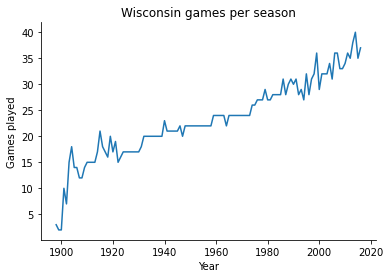

In [12]:
# It looks like they didn't play much in the early days
# How have games played changed over time?
fig, ax = plt.subplots()
ax.plot(wisc.index, wisc['gp'])

ax.set_title('Wisconsin games per season')
ax.set_xlabel('Year')
ax.set_ylabel('Games played')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('games_played.pdf', bbox_inches='tight')
plt.show()

In [13]:
# Let's look at records from 1970 onwards
wisc = wisc[wisc.index >= 1970]

In [14]:
# Let's see the revised numbers
max_wins = wisc['wins'].max()
min_wins = wisc['wins'].min()
avg_wpct = wisc['win_pct'].mean()*100
max_wpct = wisc['win_pct'].max()*100
print('Maximum wins: {0}\nMinimum wins: {1}'.format(max_wins, min_wins))
print('Average win percentage: {0:0.2f}\nMaximum win percentage {1:0.2f}'.format(avg_wpct, max_wpct))

Maximum wins: 36
Minimum wins: 0
Average win percentage: 54.28
Maximum win percentage 90.00


In [15]:
# Still at least one zero win season, let's see it
wisc[wisc.wins==0]

,market,division,current_division,gp,wins,losses,ties,win_pct
season,,,,,,,,
1983,"University of Wisconsin, Madison",1,D1,28,0,28,0,0.0
1982,"University of Wisconsin, Madison",1,D1,28,0,28,0,0.0


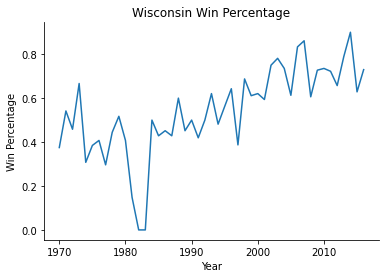

In [16]:
# How has Wisconsin's winning percentage changed over time?
fig, ax = plt.subplots()
ax.plot(wisc.index, wisc['win_pct'])

ax.set_title('Wisconsin Win Percentage')
ax.set_xlabel('Year')
ax.set_ylabel('Win Percentage')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('win_pct.pdf', bbox_inches='tight')
plt.show()

In [17]:
# Select the historical team games table
table_ref = dataset_ref.table("mbb_historical_teams_games")
table = client.get_table(table_ref)

In [18]:
# Check layout of historical team games table
table.schema

[SchemaField('season', 'INTEGER', 'NULLABLE', '[Game data] Season the game was played in', (), None),
 SchemaField('scheduled_date', 'STRING', 'NULLABLE', '[Game data] Date the game was played', (), None),
 SchemaField('attendance', 'FLOAT', 'NULLABLE', '[Game data] Attendance of the game', (), None),
 SchemaField('market', 'STRING', 'NULLABLE', '[Team data] Team school name (using Sportradar names)', (), None),
 SchemaField('name', 'STRING', 'NULLABLE', '[Team data] Team name', (), None),
 SchemaField('team_code', 'STRING', 'NULLABLE', '[Team data] School code (see http://stats.ncaa.org/game_upload/team_codes)', (), None),
 SchemaField('team_id', 'STRING', 'NULLABLE', '[Team data] Sportradar team ID', (), None),
 SchemaField('alias', 'STRING', 'NULLABLE', '[Team data] Team alias', (), None),
 SchemaField('current_division', 'STRING', 'NULLABLE', '[Team data] The division the team currently plays in', (), None),
 SchemaField('points_game', 'INTEGER', 'NULLABLE', '[Game data] Points sco

In [19]:
# Some example records
client.list_rows(table, max_results=5).to_dataframe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the tabledata.list endpoint.
  


,season,scheduled_date,attendance,market,name,team_code,team_id,alias,current_division,points_game,win,opp_market,opp_name,opp_code,opp_id,opp_alias,opp_current_division,opp_points_game
0,1997,None,NaN,University of Evansville,Aces,219,d8217105-e9c2-4267-9538-3aaeea1ae167,d8217105-e9c2-4267-9538-3aaeea1ae167,None,80,True,None,None,24361,None,None,None,46
1,2000,None,0.0,University of Evansville,Aces,219,d8217105-e9c2-4267-9538-3aaeea1ae167,d8217105-e9c2-4267-9538-3aaeea1ae167,None,83,True,None,None,24361,None,None,None,63
2,2007,15-DEC-07 12:00 AM,4583.0,University of Evansville,Aces,219,d8217105-e9c2-4267-9538-3aaeea1ae167,d8217105-e9c2-4267-9538-3aaeea1ae167,None,57,True,None,None,1115,None,None,None,44
3,1996,None,NaN,University of Evansville,Aces,219,d8217105-e9c2-4267-9538-3aaeea1ae167,d8217105-e9c2-4267-9538-3aaeea1ae167,D1,44,True,Iona College,Gaels,310,255c2a87-40c0-4989-bbb9-d286aac5d28e,IONA,D1,41
4,2000,None,0.0,University of Evansville,Aces,219,d8217105-e9c2-4267-9538-3aaeea1ae167,d8217105-e9c2-4267-9538-3aaeea1ae167,D1,66,True,Elon University,Phoenix,1068,8accb91e-6086-41b3-a420-7a82fa442365,ELON,D1,51


In [20]:
# Who has Wisconsin beat the most?
query = """
        SELECT
            market,
            opp_market as opponent,
            COUNT(1) as wins,
            AVG(attendance) as avg_attendance,
            AVG(points_game) as avg_points_for,
            AVG(opp_points_game) as avg_points_against
        FROM `bigquery-public-data.ncaa_basketball.mbb_historical_teams_games`
        WHERE team_code = "796" AND win = True
        GROUP BY market, opponent
        ORDER BY wins DESC
        LIMIT 5
        """

client = bigquery.Client()
query_job = client.query(query)
wisc = query_job.to_dataframe()
wisc.head()

Using Kaggle's public dataset BigQuery integration.


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,market,opponent,wins,avg_attendance,avg_points_for,avg_points_against
0,"University of Wisconsin, Madison",Pennsylvania State University,31,12870.640000,68.741935,54.774194
1,"University of Wisconsin, Madison","University of Minnesota, Twin Cities",28,14134.423077,68.464286,57.642857
2,"University of Wisconsin, Madison",Northwestern University,28,11376.217391,67.000000,49.464286
3,"University of Wisconsin, Madison","Indiana University, Bloomington",27,15838.923077,70.555556,58.666667
4,"University of Wisconsin, Madison","University of Illinois, Champaign",26,15635.217391,69.230769,56.461538


In [21]:
# Who has Wisconsin lost to the most?

query = """
        SELECT
            market,
            opp_market as opponent,
            COUNT(1) as losses,
            AVG(attendance) as avg_attendance,
            AVG(points_game) as avg_points_for,
            AVG(opp_points_game) as avg_points_against
        FROM `bigquery-public-data.ncaa_basketball.mbb_historical_teams_games`
        WHERE team_code = "796" AND win = False
        GROUP BY market, opponent
        ORDER BY losses DESC
        LIMIT 5
        """

client = bigquery.Client()
query_job = client.query(query)
wisc = query_job.to_dataframe()
wisc.head()

Using Kaggle's public dataset BigQuery integration.


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,market,opponent,losses,avg_attendance,avg_points_for,avg_points_against
0,"University of Wisconsin, Madison",Michigan State University,26,10965.300000,52.846154,63.038462
1,"University of Wisconsin, Madison",The Ohio State University,19,13616.066667,55.000000,63.210526
2,"University of Wisconsin, Madison",Purdue University,17,12642.466667,59.176471,68.058824
3,"University of Wisconsin, Madison","University of Illinois, Champaign",16,15799.750000,55.500000,64.687500
4,"University of Wisconsin, Madison",University of Michigan,12,12588.500000,58.750000,68.250000


In [22]:
# Query Wisconsin season information
query = """
        SELECT
            season,
            AVG(attendance) as avg_attendance,
            AVG(points_game) as avg_points_for,
            AVG(opp_points_game) as avg_points_against
        FROM `bigquery-public-data.ncaa_basketball.mbb_historical_teams_games`
        WHERE team_code = "796"
        GROUP BY season
        ORDER BY season DESC
        """

client = bigquery.Client()
query_job = client.query(query)
wisc = query_job.to_dataframe()
wisc.head()

Using Kaggle's public dataset BigQuery integration.


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,season,avg_attendance,avg_points_for,avg_points_against
0,2016,15033.837838,72.378378,62.378378
1,2015,16041.542857,67.800000,63.800000
2,2014,17777.875000,72.500000,58.175000
3,2013,16465.578947,73.500000,64.000000
4,2012,15452.771429,64.971429,55.942857


In [23]:
# Relevant season statistics
att_avg = wisc['avg_attendance'].mean()
att_max = wisc['avg_attendance'].max()
off_avg = wisc['avg_points_for'].mean()
off_max = wisc['avg_points_for'].max()
def_avg = wisc['avg_points_against'].mean()
def_min = wisc['avg_points_against'].min()
print('Average attendance: {0:0.2f}\nMaximum attendance: {1:0.2f}'.format(att_avg, att_max))
print('Average offense: {0:0.2f}\nMost points scored: {1:0.2f}'.format(off_avg, off_max))
print('Average defense: {0:0.2f}\nLeast points allowed: {1:0.2f}'.format(def_avg, def_min))

Average attendance: 13721.15
Maximum attendance: 17777.88
Average offense: 66.51
Most points scored: 73.50
Average defense: 58.93
Least points allowed: 53.19


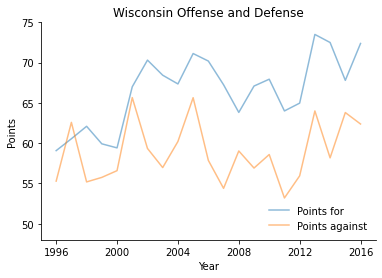

In [24]:
# How is Wisconsin's offense? How is Wisconsin's defense?

fig, ax = plt.subplots()
ax.plot(wisc.season, wisc['avg_points_for'], alpha=0.5, label='Points for')
ax.plot(wisc.season, wisc['avg_points_against'], alpha=0.5, label='Points against')

ax.legend(loc='lower right', frameon=False)
ax.set_title('Wisconsin Offense and Defense')
ax.set_xlabel('Year')
ax.set_ylabel('Points')
ax.set_xticks(range(1996, 2020, 4))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim([48,75])
plt.savefig('win_points.pdf', bbox_inches='tight')
plt.show()

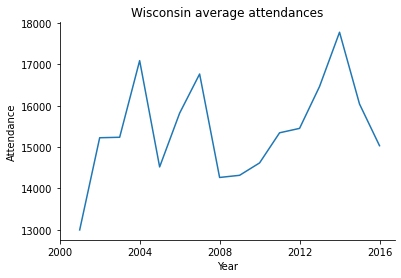

In [25]:
# How has Wisconsin's attendance changed over time?
wisc = wisc[wisc.season>=2001]

fig, ax = plt.subplots()
ax.plot(wisc.season, wisc.avg_attendance)

ax.set_title('Wisconsin average attendances')
ax.set_xlabel('Year')
ax.set_ylabel('Attendance')
ax.set_xticks(range(2000, 2020, 4))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('attendance.pdf', bbox_inches='tight')
plt.show()

In [26]:
# Select the historical tournament games table
table_ref = dataset_ref.table("mbb_historical_tournament_games")
table = client.get_table(table_ref)

In [27]:
# Check layout of historical team games table
table.schema

[SchemaField('season', 'INTEGER', 'NULLABLE', 'Year the game was played in. Note that this is different from the "season" values in other tables here, which use academic year.', (), None),
 SchemaField('round', 'INTEGER', 'NULLABLE', 'Tournament round, indicated by the number of teams playing in that round', (), None),
 SchemaField('days_from_epoch', 'INTEGER', 'NULLABLE', 'Days from epoch, as defined in the Kaggle competition (https://www.kaggle.com/c/mens-machine-learning-competition-2018/data)', (), None),
 SchemaField('game_date', 'DATE', 'NULLABLE', 'Date the game was played', (), None),
 SchemaField('day', 'STRING', 'NULLABLE', 'Day of the week the game was played', (), None),
 SchemaField('win_seed', 'STRING', 'NULLABLE', 'Seed of the winning team', (), None),
 SchemaField('win_region', 'STRING', 'NULLABLE', 'Region of the winning team, as defined in the Kaggle competition (https://www.kaggle.com/c/mens-machine-learning-competition-2018/data)', (), None),
 SchemaField('win_marke

In [28]:
# Some example records
client.list_rows(table, max_results=5).to_dataframe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the tabledata.list endpoint.
  


,season,round,days_from_epoch,game_date,day,win_seed,win_region,win_market,win_name,win_alias,...,lose_market,lose_name,lose_alias,lose_team_id,lose_school_ncaa,lose_code_ncaa,lose_kaggle_team_id,lose_pts,num_ot,academic_year
0,1994,16,8849,1994-03-25,Friday,09,W,Boston College,Eagles,BC,...,Indiana,Hoosiers,IND,c3f0a8ce-af67-497f-a750-3b859376b20a,Indiana,306,1231,68,0,1993
1,2007,64,13587,2007-03-15,Thursday,07,W,Boston College,Eagles,BC,...,Texas Tech,Red Raiders,TTU,f8c705b7-87d3-411a-9c8b-5124daab0469,Texas Tech,700,1403,75,0,2006
2,2001,64,11396,2001-03-15,Thursday,03,W,Boston College,Eagles,BC,...,Southern Utah,Thunderbirds,SUU,c7116621-45ed-4ab1-9ad9-dee524120569,Southern Utah,667,1381,65,0,2000
3,1994,64,8842,1994-03-18,Friday,09,W,Boston College,Eagles,BC,...,Washington State,Cougars,WSU,2d4f0015-adb4-4877-8c15-4a6eed7eed03,Washington St.,754,1450,64,0,1993
4,1994,32,8844,1994-03-20,Sunday,09,W,Boston College,Eagles,BC,...,North Carolina,Tar Heels,UNC,e9ca48b2-00ba-41c0-a02b-6885a2da1ff1,North Carolina,457,1314,72,0,1993


In [29]:
# Query Wisconsin tournament information
query = """
        SELECT
            season,
            round,
            win_market,
            lose_market,
            replace(ltrim(replace(win_seed,'0',' ')),' ','0') as win_seed,
            replace(ltrim(replace(lose_seed,'0',' ')),' ','0') as lose_seed,
            win_pts,
            lose_pts,
            win_pts-lose_pts as margin
        FROM `bigquery-public-data.ncaa_basketball.mbb_historical_tournament_games`
        WHERE win_code_ncaa = 796 OR lose_code_ncaa = 796
        """

client = bigquery.Client()
query_job = client.query(query)
wisc = query_job.to_dataframe()
wisc.head()

Using Kaggle's public dataset BigQuery integration.


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,season,round,win_market,lose_market,win_seed,lose_seed,win_pts,lose_pts,margin
0,2002,32,Maryland,Wisconsin,1,8,87,57,30
1,2016,16,Notre Dame,Wisconsin,6,7,61,56,5
2,2010,32,Cornell,Wisconsin,12,4,87,69,18
3,2017,16,Florida,Wisconsin,4,8,84,83,1
4,2012,16,Syracuse,Wisconsin,1,4,64,63,1


In [30]:
# Let's check out the datatypes to make sure no mischief is afoot
wisc.dtypes

season          int64
round           int64
win_market     object
lose_market    object
win_seed       object
lose_seed      object
win_pts         int64
lose_pts        int64
margin          int64
dtype: object

In [31]:
# Let's fix up the seeding data
wisc.win_seed = pd.to_numeric(wisc.win_seed)
wisc.lose_seed = pd.to_numeric(wisc.lose_seed)
wisc.dtypes

season          int64
round           int64
win_market     object
lose_market    object
win_seed        int64
lose_seed       int64
win_pts         int64
lose_pts        int64
margin          int64
dtype: object

In [32]:
# How many times has Wisconsin made it to each round?
wisc['round'].value_counts()

64    21
32    16
16    10
8      4
4      3
2      1
Name: round, dtype: int64

In [33]:
# What was Wisconsin's average seed?
win_seeds = wisc[wisc.win_market=='Wisconsin']['win_seed'].sum()
lose_seeds = wisc[wisc.lose_market=='Wisconsin']['lose_seed'].sum()
total = wisc.shape[0]
avg_seed = (win_seeds+lose_seeds)/total
print('Wisconsin\'s average seed was {0:0.2f}'.format(avg_seed))

Wisconsin's average seed was 5.22


In [34]:
# How did Wisconsin fare when they made it to the finals?
wisc[wisc['round']==2]

,season,round,win_market,lose_market,win_seed,lose_seed,win_pts,lose_pts,margin
20,2015,2,Duke,Wisconsin,1,1,68,63,5


In [35]:
# What was Wisconsin's largest margin of victory?
wisc[wisc.win_market=='Wisconsin'].sort_values('margin', ascending=False).head()

,season,round,win_market,lose_market,win_seed,lose_seed,win_pts,lose_pts,margin
38,2014,64,Wisconsin,American University,2,15,75,35,40
8,2012,64,Wisconsin,Montana,4,13,73,49,24
40,2014,16,Wisconsin,Baylor,2,6,69,52,17
18,2008,32,Wisconsin,Kansas State,3,11,72,55,17
19,2008,64,Wisconsin,Cal State Fullerton,3,14,71,56,15


In [36]:
# What was the margin in Wisconsin's greatest defeat?
wisc[wisc.lose_market=='Wisconsin'].sort_values('margin', ascending=False).head()

,season,round,win_market,lose_market,win_seed,lose_seed,win_pts,lose_pts,margin
0,2002,32,Maryland,Wisconsin,1,8,87,57,30
32,2006,64,Arizona,Wisconsin,8,9,94,75,19
2,2010,32,Cornell,Wisconsin,12,4,87,69,18
17,2008,16,Davidson,Wisconsin,10,3,73,56,17
5,1997,64,Texas,Wisconsin,10,7,71,58,13


In [37]:
# What teams did Wisconsin beat the most?
wisc[wisc.win_market=='Wisconsin'].lose_market.value_counts()[:5]

Arizona         3
Oregon          2
Kansas State    2
Villanova       1
Bucknell        1
Name: lose_market, dtype: int64

In [38]:
# What teams did Wisconsin lose to the most?
wisc[wisc.lose_market=='Wisconsin'].win_market.value_counts()[:5]

Kentucky         2
Georgia State    1
Duke             1
UNLV             1
Notre Dame       1
Name: win_market, dtype: int64

In [39]:
# How many times did Wisconsin upset?
wisc[(wisc.win_market=='Wisconsin') & (wisc.win_seed > wisc.lose_seed)]

,season,round,win_market,lose_market,win_seed,lose_seed,win_pts,lose_pts,margin
11,2017,32,Wisconsin,Villanova,8,1,65,62,3
12,2009,64,Wisconsin,Florida State,12,5,61,59,2
13,2016,32,Wisconsin,Xavier,7,2,66,63,3
37,2014,8,Wisconsin,Arizona,2,1,64,63,1
41,2000,8,Wisconsin,Purdue,8,6,64,60,4
42,2000,16,Wisconsin,LSU,8,4,61,48,13
43,1994,64,Wisconsin,Cincinnati,9,8,80,72,8
45,2000,32,Wisconsin,Arizona,8,1,66,59,7


In [40]:
# How many times did Wisconsin choke?
wisc[(wisc.lose_market=='Wisconsin') & (wisc.win_seed > wisc.lose_seed)]

,season,round,win_market,lose_market,win_seed,lose_seed,win_pts,lose_pts,margin
2,2010,32,Cornell,Wisconsin,12,4,87,69,18
5,1997,64,Texas,Wisconsin,10,7,71,58,13
16,1999,64,Missouri State,Wisconsin,12,5,43,32,11
17,2008,16,Davidson,Wisconsin,10,3,73,56,17
21,2001,64,Georgia State,Wisconsin,11,6,50,49,1
23,2014,4,Kentucky,Wisconsin,8,2,74,73,1
24,2011,16,Butler,Wisconsin,8,4,61,54,7
34,2007,32,UNLV,Wisconsin,7,2,74,68,6
53,2013,64,Ole Miss,Wisconsin,12,5,57,46,11
